In [42]:
import krakenex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from requests.exceptions import HTTPError

In [78]:
kraken = krakenex.API()

In [144]:
def get_order_book(pair, count):
    """Queries the kraken order book.

    Parameters
    ----------
    pair : str 
        Asset pair to get market depth for.
    count : int 
        Maximum number of asks/bids

    Returns
    -------
    dataframe
        Order book as dataframe with columns price, volume, timestamp, type, cumvolume, relprice.
    """
    
    try:
        response = kraken.query_public('Depth', {'pair': pair, 'count': count})
    except HTTPError as e:
        print("ERROR: Failed getting order book data for pair={}".format(pair))
    
    obook = response.get('result', {}).get(pair)
    if not obook:
        print("WARNING: Empty response.")
    else:
        # add cumvolume
        asks = [limorder + ['ask'] for limorder in obook['asks']]
        bids = [limorder + ['bid'] for limorder in obook['bids']]
        tabular = asks + bids
        obook = pd.DataFrame(tabular, columns=['price', 'volume', 'timestamp', 'type'])            
        obook = obook.apply(pd.to_numeric, errors='ignore')
        obook['cumvolume'] = obook[['type', 'volume']].groupby('type').cumsum()  # assumes rows are sorted
        
        # add relprice
        minask = obook.loc[obook['type'] == 'ask', 'price'].min()
        maxbid = obook.loc[obook['type'] == 'bid', 'price'].max()
        spread = minask - maxbid
        midprice = (minask + maxbid) / 2
        obook['relprice'] = 100 * (obook['price'] - midprice) / midprice
        
    return obook


def plot_order_book(ob):
    """Plots the cumulative volume and order distribution of the order book.
    
    Paramaters
    ----------
    ob : dataframe
        Order book data frame with columns type, price, volume, cumvolume, relprice.
    """
    
    # extract data series from df
    ask_prices = ob.loc[ob['type'] == 'ask', 'price']
    ask_relprices = ob.loc[ob['type'] == 'ask', 'relprice']
    ask_volumes = ob.loc[ob['type'] == 'ask', 'volume']
    ask_cumvolumes = ob.loc[ob['type'] == 'ask', 'cumvolume']
    bid_prices = ob.loc[ob['type'] == 'bid', 'price']
    bid_relprices = ob.loc[ob['type'] == 'bid', 'relprice']
    bid_volumes = ob.loc[ob['type'] == 'bid', 'volume']
    bid_cumvolumes = ob.loc[ob['type'] == 'bid', 'cumvolume']
    
    # plot cum vol plot
    fig, ax = plt.subplots(2, 1, figsize=(16, 10))  # sharex='col'
    ax[0].fill_between(bid_relprices, bid_cumvolumes, facecolor='maroon', edgecolor='k', alpha=0.7, zorder=10, label='bids')
    ax[0].fill_between(ask_relprices, ask_cumvolumes, facecolor='dimgrey', edgecolor='k', alpha=0.7, zorder=10, label='asks')
    ax[0].set_xlim([min(bid_relprices.min(), ask_relprices.min()), max(bid_relprices.max(), ask_relprices.max())])
    ax[0].set_ylim([0, 1.05* max(bid_cumvolumes.max(), ask_cumvolumes.max())])
    ax[0].set_xlabel('Distance to midprice (%)')
    ax[0].set_ylabel('Cumulative Volume')
    ax[0].legend(loc='upper center', facecolor='white', framealpha=1, frameon=False)
    
    # plot order distribution
    ax[1].stem(bid_prices, bid_volumes, 'maroon', markerfmt=' ', label='bids')
    ax[1].stem(ask_prices, ask_volumes, 'k', markerfmt=' ', label='asks')
    ax[1].set_ylim([0, 1.05* max(bid_volumes.max(), ask_volumes.max())])
    ax[1].set_xlabel('Price')
    ax[1].set_ylabel('Volume')
    
    plt.show()

In [150]:
N = 100
ob = get_order_book('XXRPZEUR', N)
ob.head()

,price,volume,timestamp,type,cumvolume,relprice
0,0.27201,41335.476,1552359858,ask,41335.476,0.001838
1,0.27202,18714.678,1552359760,ask,60050.154,0.005515
2,0.27203,10000.000,1552359712,ask,70050.154,0.009191
3,0.27233,55636.829,1552359849,ask,125686.983,0.119483
4,0.27236,1600.000,1552359745,ask,127286.983,0.130512


In [151]:
# groups = df.groupby(by=['A'])
# print(groups.apply(lambda g: g[g['B'] == g['B'].max()]))

threshold = ob.volume.nlargest(int(0.8 * N)).min()
ob_sub = ob.groupby('type').apply(lambda x: x[x['volume'] > threshold])

In [152]:
ob_sub.shape

(79, 6)

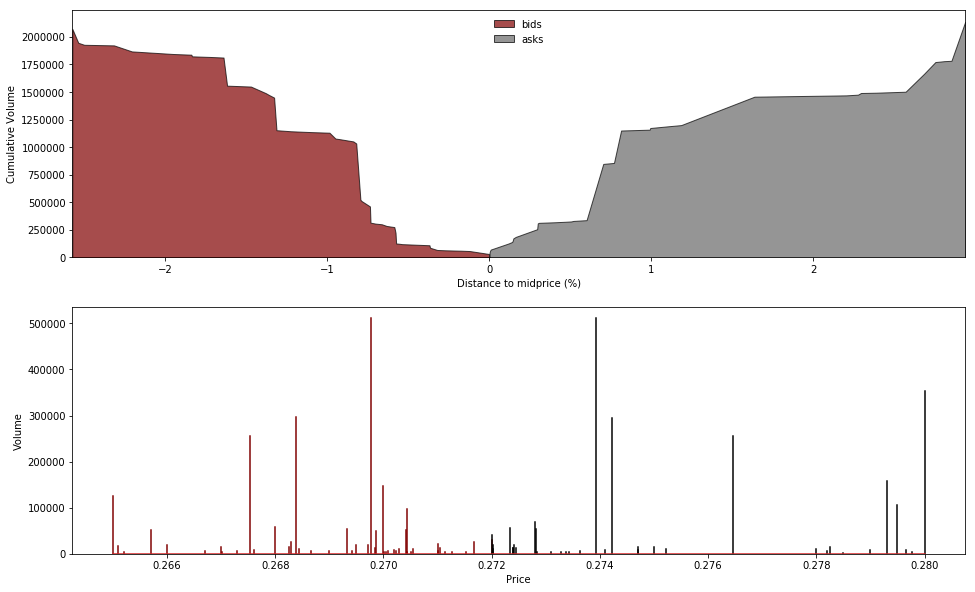

In [153]:
plot_order_book(ob_sub)

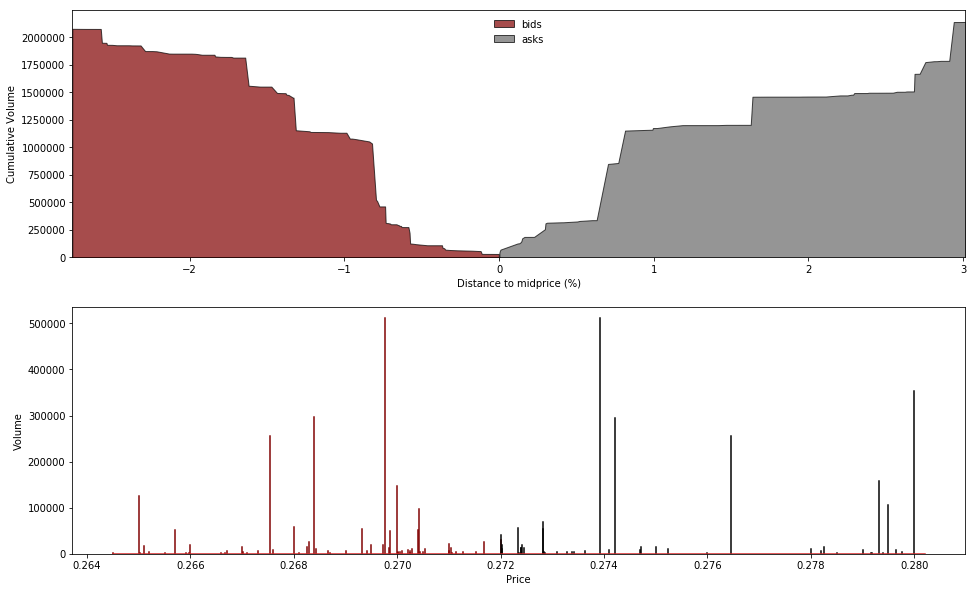

In [296]:
plot_order_book(ob)

In [292]:
def resistivity(midpoint, diff, ob):
    """A measure of the relative money needed to move the price from the midprice given the current orders. 
    
    Note that this is normalized by the area of +/- diff about the midprice.

    midprice: float 
        The midpoint of the spread.
    diff : float
        The relative amount in percentage terms you want the price to move from the midpoint.
    ob : dataframe
        The orderbook dataframe or ask / bid dataframe.
    """
    
    oneside = ob[np.less(np.absolute(ob['relprice']), abs(diff)) & (np.sign(ob['relprice']) == np.sign(diff))]
    bothsides = ob[np.less(np.absolute(ob['relprice']), abs(diff))]
    onesidemoney = np.sum(oneside['price'] * oneside['volume'])
    totalmoney = np.sum(bothsides['price'] * bothsides['volume'])
    
    return onesidemoney / totalmoney

def summarize_order_book(ob):
    
    asks = ob[ob['type'] == 'ask']
    bids = ob[ob['type'] == 'bid']
    minask = asks.price.min()
    maxbid = bids.price.max()
    
    spread = minask - maxbid
    midprice = (minask + maxbid) / 2
    spreadperc = 100 * spread / midprice
    
    # first cliff detection
    # define fc as largest vol order within delta% of midpoint
    fc_bounds = 2.0  # percent
    fc_ask = asks.loc[asks.loc[asks['relprice'] > fc_bounds, 'volume'].idxmax()]
    fc_bid = bids.loc[bids.loc[bids['relprice'] > -fc_bounds, 'volume'].idxmax()]
    
    # size of first cliff
    # define sfc as sum of volumes of orders within epsilon% of cliff
    sfc_bounds = 0.1  # percent
    sfc_ask = asks.loc[np.absolute(asks['relprice'] - fc_ask['relprice']) < sfc_bounds, 'volume'].sum()
    sfc_bid = bids.loc[np.absolute(bids['relprice'] - fc_bid['relprice']) < sfc_bounds, 'volume'].sum()
    
    # TODO:
#     Money / volume needed to move price to first cliff edge
#     Money / volume needed to move price to nth interval of first cliff edge
#     USD?
#     divide ask by bids or vice versa to see who has the relative upper hand against percent move from midprice
    
    
    return midprice, spread, spreadperc

In [297]:
midprice, spread, spreadperc = summarize_order_book(ob)
resistivity(spread, -0.8, ob)

0.37647299249965543

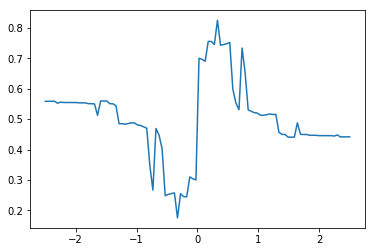

In [299]:
x = np.linspace(-2.5, 2.5, 100)
y = [resistivity(spread, xi, ob) for xi in x]
plt.plot(x,y)
# better signal: divide the cumulative money of orders at x% from midpoint from ask and bid

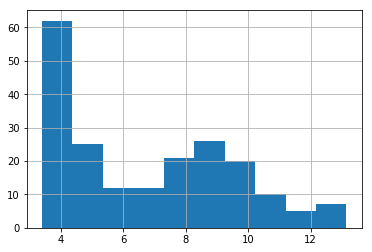

In [215]:
np.log(ob.volume).hist(bins=10);

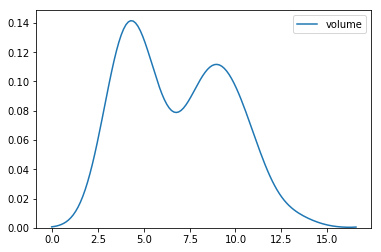

In [121]:
sns.kdeplot(np.log(ob.volume));

In [60]:
np.exp(6.5)

665.1416330443618